In [163]:
import jax
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import optax

BATCH_SIZE = 100
LEARNING_RATE = 1e-3
LAYER_SIZES = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
NUM_EPOCHS = 4_000
OPTIMIZER = optax.adam(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.yogi(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.adabelief(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.fromage
#OPTIMIZER = optax.optimistic_gradient_descent(learning_rate=LEARNING_RATE)
ACTIVATION = jnp.tanh
#ACTIVATION = jax.nn.relu
#ACTIVATION = jax.nn.sigmoid
#ACTIVATION = jax.nn.silu
#ACTIVATION = jax.nn.softplus
#ACTIVATION = jax.nn.softmax

L = 1.0
N = jnp.array([1, 2, 3, 4]) # Quantum Numbers
t = jnp.linspace(start=0, stop=L, num=1000)

- See [Activation Functions](https://jax.readthedocs.io/en/latest/jax.nn.html?highlight=sigmoid) for a list of possible activations.
- See [Optimizers](https://optax.readthedocs.io/en/latest/api.html#optax.yogi) for a list of optimizers.

In [164]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,1))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  """
  returns:
  <list> of length: (#layers - 1)

  Each list item contains a <tuple> of len(): 2 (Weights and Biases)

  Each tuple consists of 2 Arrays of dimension: 

  """
  
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

initial_params = init_network_params(LAYER_SIZES, random.PRNGKey(0))

In [165]:
def net(params, x, n):
    activations = jnp.array([x, n]).reshape(2,1)
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = ACTIVATION(outputs)

    final_w, final_b = params[-1]
    output = jnp.dot(final_w, activations) + final_b
    return output.reshape()

# check
net(initial_params, 2., 2)

Array(-0.0107695, dtype=float32)

We want to train the neural network for the Schrödinger equation of a particle in a 1-D box:

$$
\hat{H} \psi(x) = E\psi(x)
$$

Under certain assumptions this becomes a 2nd order homogeneous linear differential equation:

$$
\ddot \psi_n(x) + \frac{2mE_n}{\hbar^2} \psi(x) = 0,
$$

Where E is dependent on the quantum number n:

$$
E_n = \frac{\hbar^2 \pi^2 n^2}{2mL^2}
$$

The boundary conditions are given as:

$$
\psi(0) = \psi(L) = 0
$$


Therefore we define an objective 

$$
\mathcal{L}(\mathbf{W}) = \frac{1}{M}\sum_{i=1}^M (\ddot \psi_\mathbf{W} + \frac{2mE}{\hbar^2} \psi_\mathbf{W}) ^ 2 + (\psi_\mathbf{W}(0) - \psi_0) ^ 2 + (\psi_\mathbf{W}(L) - \psi_L) ^ 2
$$

In [166]:
def a(n):
    return (n ** 2) * (np.pi ** 2)

y0_0 = 0.
y0_L = 0.

#@jit
def ode(params, x, n):
    nn = lambda x: net(params, x, n)
    dnn = jax.grad(nn, argnums=0)
    ddnn = jax.grad(dnn, argnums=0)
    return ddnn(x) + a(n) * nn(x)

# check
ode(initial_params, 3., 2)

Array(-0.42516282, dtype=float32)

In [167]:
ode_batched = jax.vmap(ode, in_axes=[None, 0, None])
net_batched = jax.vmap(net, in_axes=[None, 0, None])

#@jit
def loss(params: optax.Params, batch: jnp.ndarray, n: np.ScalarType) -> jnp.ndarray:
    y_hat = ode_batched(params, batch, n)
    ode_loss = jnp.mean(y_hat ** 2)

    init_loss_1 = (net(params, 0., n) - y0_0) ** 2
    init_loss_2 = (net(params, L, n) - y0_L) ** 2
    init_loss_3 = jnp.abs(1/(jax.grad(net, argnums=1))(params, 0., n))

    return ode_loss + init_loss_1 + init_loss_2 + init_loss_3

# check
loss(initial_params, jnp.array([1., 2.]), 4)

Array(7.221346e+13, dtype=float32)

In [168]:
key = jax.random.PRNGKey(42)

def fit(params: optax.Params, optimizer: optax.GradientTransformation, n: np.ScalarType, key) -> optax.Params:
  opt_state = optimizer.init(params)

  @jit
  def step(params, opt_state, batch, n):
    loss_value, grads = jax.value_and_grad(loss)(params, batch, n)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for epoch in range(NUM_EPOCHS):
      shuffle_key, key = jax.random.split(key)
      batches = jax.random.permutation(shuffle_key, t)
      batches = batches.reshape(BATCH_SIZE, -1)
      for batch in batches:
          for n in N:
            params, opt_state, loss_value = step(params, opt_state, batch, n)
      if epoch % 100 == 0:
          print(f'epoch {epoch}, loss: {loss_value}')

  return params

train_key, key = jax.random.split(key)
params = fit(initial_params, OPTIMIZER, N, key)


epoch 0, loss: 6157511680.0
epoch 100, loss: 55.686668395996094
epoch 200, loss: 3.3988218307495117
epoch 300, loss: 2.580467939376831
epoch 400, loss: 4.570253849029541
epoch 500, loss: 1.0197136402130127
epoch 600, loss: 0.7603448033332825
epoch 700, loss: 0.9902294874191284
epoch 800, loss: 1.1575212478637695
epoch 900, loss: 0.6184713244438171
epoch 1000, loss: 0.6689959764480591
epoch 1100, loss: 0.6597276329994202
epoch 1200, loss: 1.624359369277954
epoch 1300, loss: 0.990073025226593
epoch 1400, loss: 0.6041898131370544
epoch 1500, loss: 2.8939313888549805
epoch 1600, loss: 1.8776341676712036
epoch 1700, loss: 1.27213716506958
epoch 1800, loss: 0.8464583158493042
epoch 1900, loss: 1.8204265832901
epoch 2000, loss: 0.8369858264923096
epoch 2100, loss: 0.7845643162727356
epoch 2200, loss: 0.6931442022323608
epoch 2300, loss: 1.4642915725708008
epoch 2400, loss: 0.7577495574951172
epoch 2500, loss: 0.8941880464553833
epoch 2600, loss: 1.343597173690796
epoch 2700, loss: 0.973966598

In [169]:
def sol(t, n):
    return np.sqrt(2/L) * np.sin(n * np.pi * t/L)

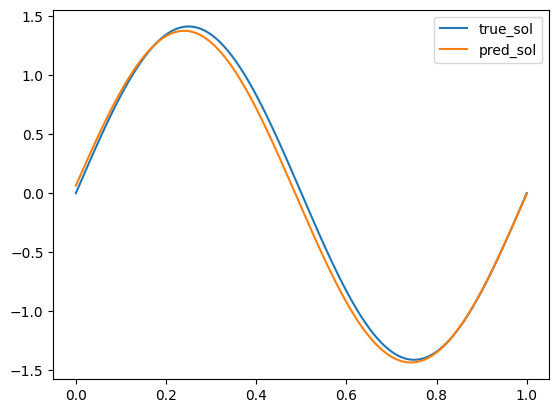

In [174]:
import matplotlib.pyplot as plt
N = 2

model = jax.vmap(lambda t: net(params, t, N))
model_2 = model(t) ** 2
integral = np.trapz(model_2, t)

plt.plot(t, sol(t, N), label='true_sol')
plt.plot(t, model(t)*1/np.sqrt(integral), label='pred_sol')
plt.legend()